In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('./data/processed/main.csv')

In [3]:
data.head()

,Zipcode,public_transport,shop,schools,bike_rental,parking,population_density,city
0,50309,196,100,0,24,2,1914.0,Des Moines
1,50310,6,86,0,0,0,3752.0,Des Moines
2,50311,46,34,0,8,0,6011.0,Des Moines
3,50312,52,44,0,2,2,2701.0,Des Moines
4,50313,46,10,0,0,0,963.0,Des Moines


In [4]:
numerical_cat = ['bike_rental', 'parking', 'public_transport', 'schools', 'shop', 'population_density']

# Data normalization

In [5]:
df_norm = data.copy()

In [11]:
df_norm.head()

,Zipcode,public_transport,shop,schools,bike_rental,parking,population_density,city
0,50309,0.117718,0.758801,0.0,0.352941,0.045455,0.040668,Des Moines
1,50310,0.002427,0.738383,0.0,0.000000,0.000000,0.093160,Des Moines
2,50311,0.026699,0.612757,0.0,0.117647,0.000000,0.157675,Des Moines
3,50312,0.030340,0.647660,0.0,0.029412,0.045455,0.063144,Des Moines
4,50313,0.026699,0.447088,0.0,0.000000,0.000000,0.013508,Des Moines


In [7]:
# Logarithmic normalization of the 'shop' row
df_norm['shop'] = np.clip(np.log(df_norm['shop'],), -1, float('inf'))

/Users/jettchen/anaconda3/envs/himcm/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


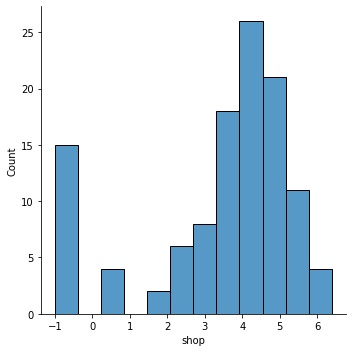

In [8]:
sns.displot(df_norm, x='shop')

In [9]:
df_train = df_norm[df_norm['bike_rental']>0]
for cat in numerical_cat:
    df_norm[cat] = (df_norm[cat] - df_norm[cat].min()) / (df_norm[cat].max() - df_norm[cat].min())
    df_train[cat] = ((df_train[cat] - df_train[cat].min()) / (df_train[cat].max() - df_train[cat].min()))

/var/folders/8f/hqry7rvj7yb88tw1zthzjlzh0000gn/T/ipykernel_36592/3047956262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cat] = ((df_train[cat] - df_train[cat].min()) / (df_train[cat].max() - df_train[cat].min()))


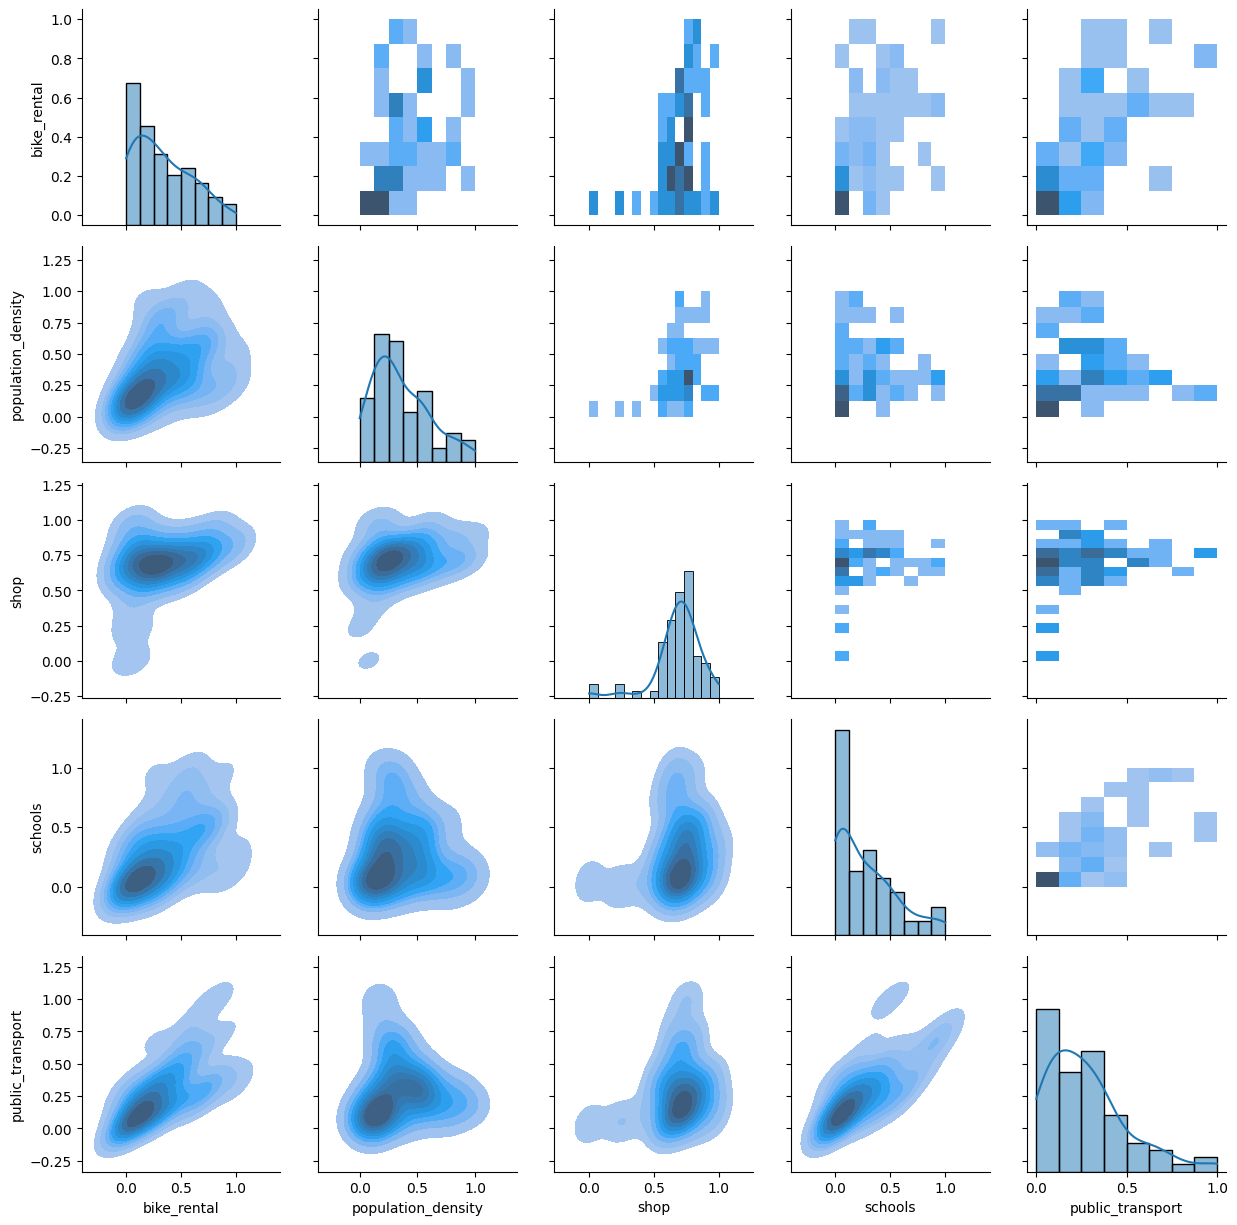

In [10]:
g = sns.PairGrid(df_train[['bike_rental', 'population_density', 'shop', 'schools', 'public_transport']])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

# Get the weights of the model

In [ ]:
correlation = data.corr()
correlation

In [12]:
correlation = df_train.corr()
correlation

,Zipcode,public_transport,shop,schools,bike_rental,parking,population_density
Zipcode,1.000000,-0.185455,0.272089,-0.012505,-0.256558,0.359708,-0.130633
public_transport,-0.185455,1.000000,0.251078,0.714064,0.665371,-0.157267,0.002092
shop,0.272089,0.251078,1.000000,0.215484,0.365675,0.210633,0.343373
schools,-0.012505,0.714064,0.215484,1.000000,0.509166,-0.103132,-0.010867
bike_rental,-0.256558,0.665371,0.365675,0.509166,1.000000,-0.091594,0.403652
parking,0.359708,-0.157267,0.210633,-0.103132,-0.091594,1.000000,0.061968
population_density,-0.130633,0.002092,0.343373,-0.010867,0.403652,0.061968,1.000000


In [13]:
weights = correlation['bike_rental'][['parking', 'public_transport', 'schools', 'shop', 'population_density']]
weights

parking              -0.091594
public_transport      0.665371
schools               0.509166
shop                  0.365675
population_density    0.403652
Name: bike_rental, dtype: float64

In [14]:
weights_np = weights.to_numpy()
pcols = ['parking', 'public_transport', 'schools', 'shop', 'population_density']
df_norm['score'] = df_norm.apply(lambda x: np.dot(weights_np, x[pcols].to_numpy()), axis=1)

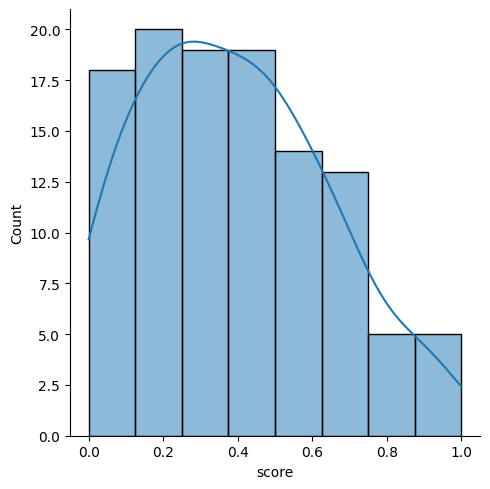

In [15]:
df_norm['score'] = (df_norm['score'] - np.min(df_norm['score'])) / (np.max(df_norm['score']) - np.min(df_norm['score']))
sns.displot(df_norm, x='score', kde=True)

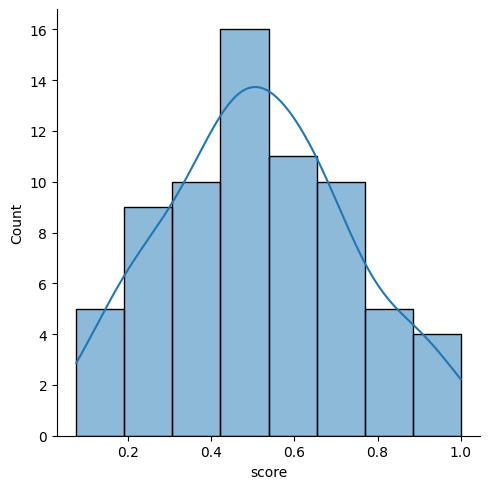

In [16]:
sns.displot(df_norm[df_norm['bike_rental']>0], x='score', kde=True)

<AxesSubplot:xlabel='score', ylabel='bike_rental'>

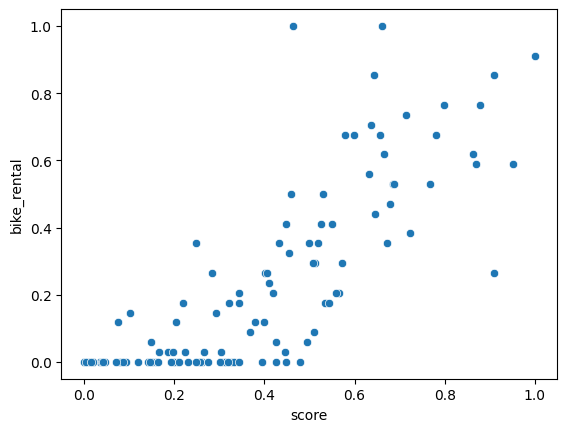

In [17]:
sns.scatterplot(x='score', y='bike_rental', data=df_norm)

In [18]:
df_norm['relative_score'] = df_norm['score'] - df_norm['bike_rental']
df_norm['relative_score'] = (df_norm['relative_score']- df_norm['relative_score'].min()) / (df_norm['relative_score'].max() - df_norm['relative_score'].min())

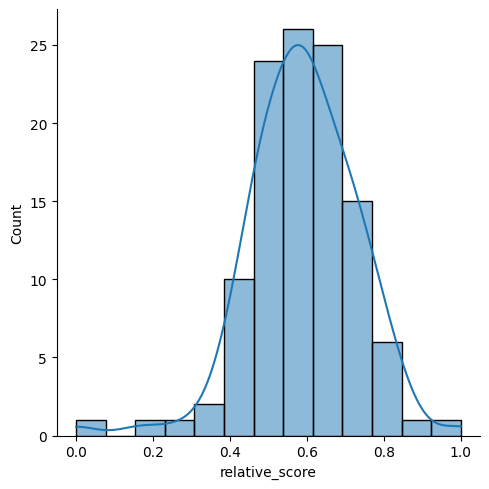

In [19]:
sns.displot(df_norm, x='relative_score', kde=True)

# Results

In [20]:
cities = ['Chicago', 'Des Moines', 'Denver']
res = dict()
for city in cities:
    res[city] = df_norm[df_norm['city']==city].sort_values(by=['relative_score'], ascending=False)[['Zipcode', 'relative_score']]
    res[city].to_csv(f'./data/results/{city}_relative_rank.csv', index=False)

In [21]:
df_norm.head()

,Zipcode,public_transport,shop,schools,bike_rental,parking,population_density,city,score,relative_score
0,50309,0.117718,0.758801,0.0,0.352941,0.045455,0.040668,Des Moines,0.249382,0.366391
1,50310,0.002427,0.738383,0.0,0.000000,0.000000,0.093160,Des Moines,0.207455,0.629437
2,50311,0.026699,0.612757,0.0,0.117647,0.000000,0.157675,Des Moines,0.204785,0.527676
3,50312,0.030340,0.647660,0.0,0.029412,0.045455,0.063144,Des Moines,0.185444,0.585946
4,50313,0.026699,0.447088,0.0,0.000000,0.000000,0.013508,Des Moines,0.120130,0.555581


## Zip Code Ranking based on relative score for each of the cities

In [22]:
res['Chicago']

,Zipcode,relative_score
36,60620,1.000000
52,60638,0.821849
64,60652,0.813495
45,60630,0.806389
43,60628,0.761454
...,...,...
26,60610,0.388579
41,60625,0.371034
61,60647,0.276145
34,60618,0.167782


In [23]:
res['Denver']

,Zipcode,relative_score
96,80219,0.858921
97,80220,0.833728
85,80204,0.810872
108,80237,0.788803
91,80211,0.764767
86,80205,0.764355
99,80222,0.745469
89,80209,0.734980
88,80207,0.732177
113,80249,0.724968


In [24]:
res['Des Moines']

,Zipcode,relative_score
1,50310,0.629437
6,50315,0.595583
7,50317,0.589729
3,50312,0.585946
9,50320,0.582509
4,50313,0.555581
5,50314,0.529932
2,50311,0.527676
0,50309,0.366391
8,50319,NaN


# Publishing

In [ ]:
import dataframe_image as dfi

In [ ]:
for city in cities:
    dfi.export(res[city], f'./data/export/{city}.png')

In [ ]:
print(res['Chicago'].to_latex(index=False, multirow=True))